# Sequential Model: Refresher

This notebook is a quick refresher of [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model and based on the [Sequential Model](https://www.tensorflow.org/guide/keras/sequential_model) guide.

## Setup

As usual, prepare environment as a first step:

In [1]:
import os 

# Suppress unwnted TF logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# Fix duplicated CUDA paths (only on my current env):
from socket import gethostname
if gethostname() == 'stepan-pc':
    OTHER_PATHS = os.environ['PATH']
    CUDA_12_5_PATH = '/usr/local/cuda-12.5/bin'
    os.environ['PATH']=f'{CUDA_12_5_PATH}:{OTHER_PATHS}'

Then import libs:

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt

## tf.keras.Sequential

The [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) is a simple way to combine multiple layers into a single model in a simplest possible way (a linear graph of layers). 

The main idea here is that Keras API provide a model abstraction and a ways to combine models into more complex ones (implementing the same API). 

Lets create sn example model:

In [3]:
some_seq_model = keras.Sequential([
    keras.layers.Dense(units=2, activation=tf.nn.relu, name="layer_1"),
    keras.layers.Dense(units=3, activation=tf.nn.relu, name="layer_2"),
    keras.layers.Dense(units=4, activation=tf.nn.relu, name="layer_3"),
])

And equivalent bunch of layers:

In [4]:
layer_1 = keras.layers.Dense(units=2, activation=tf.nn.relu, name="layer_1")
layer_2 = keras.layers.Dense(units=3, activation=tf.nn.relu, name="layer_2")
layer_3 = keras.layers.Dense(units=4, activation=tf.nn.relu, name="layer_3")

Now applying the model and applyin equivalent layers sequentially will yield identical results:

In [5]:
x = tf.ones((3, 3))

In [6]:
some_seq_model(x)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.        , 0.65918905, 0.        , 0.41696048],
       [0.        , 0.65918905, 0.        , 0.41696048],
       [0.        , 0.65918905, 0.        , 0.41696048]], dtype=float32)>

In [7]:
layer_3(layer_2(layer_1(x)))

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.        , 0.13578887, 0.        , 0.        ],
       [0.        , 0.13578887, 0.        , 0.        ],
       [0.        , 0.13578887, 0.        , 0.        ]], dtype=float32)>

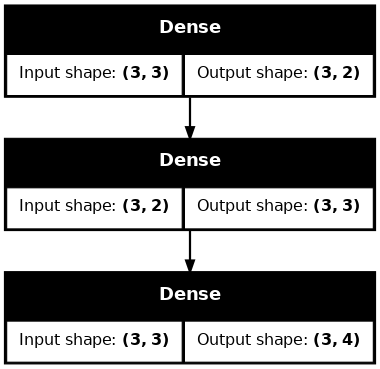

In [14]:
keras.utils.plot_model(some_seq_model, "some_seq_model.png", show_shapes=True, dpi=80)

## Creating a Sequential Model

As shown above the sequential model coudl be created by passing a list of layers to the constructor:

In [15]:
model = keras.Sequential([
    keras.layers.Dense(units=2, activation=tf.nn.relu),
    keras.layers.Dense(units=3, activation=tf.nn.relu),
    keras.layers.Dense(units=4),
])

Layers are accessible via the `layers` attribute:

In [16]:
model.layers

[<Dense name=dense, built=False>,
 <Dense name=dense_1, built=False>,
 <Dense name=dense_2, built=False>]

Model could be created incrementally:

In [19]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=2, activation=tf.nn.relu))
model.add(keras.layers.Dense(units=3, activation=tf.nn.relu))
model.add(keras.layers.Dense(units=4))
model.layers

[<Dense name=dense_6, built=False>,
 <Dense name=dense_7, built=False>,
 <Dense name=dense_8, built=False>]

Note that there is also the corresponding `pop()` method to remove layers. Also note that `Sequential` constructor also accepts `name` parameter as any other `Model` implementation.

## Specifying input shape in advance

Generally, all layers need to know input shape in order to allocate its weights. So without input shape each layer weights are empty. Weights are actually allocated only when the model is called for the first time inside the `build(input_shape)` method:

In [20]:
layer = keras.layers.Dense(units=3) # input_shape is not provided
layer.weights # Emtpy

[]

In [21]:
inputs = tf.ones((1,4))
outputs = layer(inputs)
layer.weights

[<KerasVariable shape=(4, 3), dtype=float32, path=dense_9/kernel>,
 <KerasVariable shape=(3,), dtype=float32, path=dense_9/bias>]

The same logic applies to the `Sequential` model. 

In [22]:
model.weights

[]

In [23]:
model(inputs)
model.weights

[<KerasVariable shape=(4, 2), dtype=float32, path=sequential_3/dense_6/kernel>,
 <KerasVariable shape=(2,), dtype=float32, path=sequential_3/dense_6/bias>,
 <KerasVariable shape=(2, 3), dtype=float32, path=sequential_3/dense_7/kernel>,
 <KerasVariable shape=(3,), dtype=float32, path=sequential_3/dense_7/bias>,
 <KerasVariable shape=(3, 4), dtype=float32, path=sequential_3/dense_8/kernel>,
 <KerasVariable shape=(4,), dtype=float32, path=sequential_3/dense_8/bias>]

In [24]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (1, 2)                 │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 3)                 │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (1, 4)                 │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35 (140.00 B)

 Trainable params: 35 (140.00 B)

 Non-trainable params: 0 (0.00 B)

## Common debugging process: add() + summary()

Sometimes it is usefull to monitor model construction process by calling `summary()` from time to time, for example to check current output shape when multiple [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers are applied:

In [25]:
model = keras.Sequential()
model.add(keras.Input(shape=(250, 250, 3))) # 250x250 RGB images
model.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.relu))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D(pool_size=3))

It is not so easy to guess what is the output size at the moment. Let's check it:

In [26]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 123, 123, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 121, 121, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,680 (45.62 KB)

 Trainable params: 11,680 (45.62 KB)

 Non-trainable params: 0 (0.00 B)

**NOTE**: The output size is `40x40` so we can keep downsampling:

In [28]:
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D(pool_size=3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu))
model.add(keras.layers.MaxPooling2D(pool_size=2))

And now?

In [30]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 123, 123, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 121, 121, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,672 (190.12 KB)

 Trainable params: 48,672 (190.12 KB)

 Non-trainable params: 0 (0.00 B)

Now output shape is `4x4`. Let's apply [GlobalMaxPooling2D](https://keras.io/api/layers/pooling_layers/global_max_pooling2d/).  

In [31]:
model.add(keras.layers.GlobalMaxPooling2D()) # Find max feature activations across the image
model.add(keras.layers.Dense(units=10)) # Add a linear classification layer

In [32]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 123, 123, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 121, 121, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 36, 36, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,002 (191.41 KB)

 Trainable params: 49,002 (191.41 KB)

 Non-trainable params: 0 (0.00 B)

## Feature Extraction with a Sequential Model

The `Sequential` model is a special case of [Functional API](https://www.tensorflow.org/guide/keras/functional_api): a model that has `inputs` and `outputs` as a pseudo-values, that could be used to draw arbitrary computational graph topologies (where atomic nodes are also `Model`s). 

Every layer, that the `Sequential` model is built upon also has its `input` and `output` attributes that could be used for different tasks where intermediate features are required. 

Here is how intermediate feautres could be extracted:

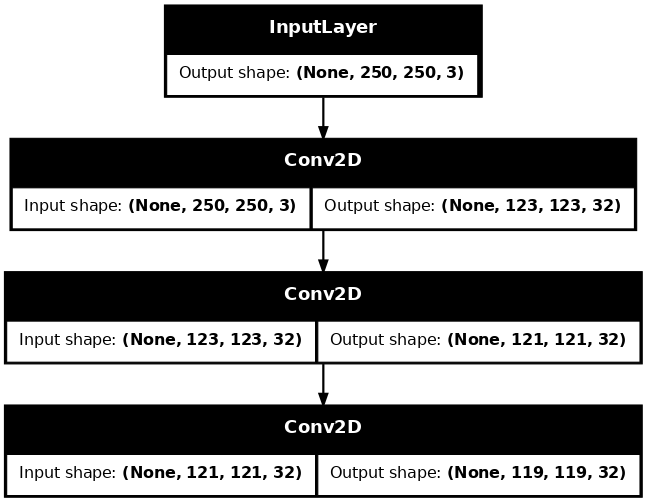

In [45]:
initial_model = keras.Sequential([
    keras.Input(shape=(250,250,3)),
    keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.relu),
    keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu),
    keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu),
])

feature_extractor = keras.Model(
    inputs=initial_model.inputs,
    outputs=[layer.output for layer in initial_model.layers],
)

keras.utils.plot_model(feature_extractor, show_shapes=True, dpi=80)

In [43]:
x = tf.ones((1, 250, 250, 3))
features = feature_extractor(x) # List of tensors
[t.shape for t in features]

[TensorShape([1, 123, 123, 32]),
 TensorShape([1, 121, 121, 32]),
 TensorShape([1, 119, 119, 32])]

Example with a single layer feature extraction:

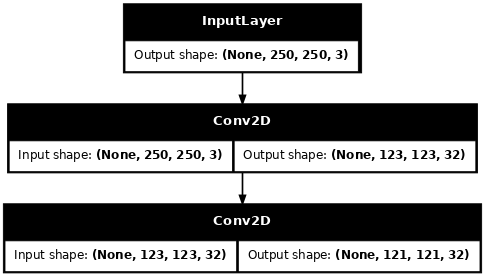

In [52]:
initial_model = keras.Sequential([
    keras.Input(shape=(250,250,3)),
    keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.relu),
    keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu),
    keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu),
])

feature_extractor = keras.Model(
    inputs=initial_model.inputs, 
    outputs=initial_model.layers[1].output,
)

keras.utils.plot_model(feature_extractor, show_shapes=True, dpi=60)

In [53]:
x = tf.ones((1, 250, 250, 3))
feature_extractor(x).shape

TensorShape([1, 121, 121, 32])

## Transfer Learning with a Sequential model

Transfer Learning is transferring knowledge from one machine learning model to another. One of the most commonly used technique for transfer learning is freezing the bottom layers of some pretrained model and only training some new layers added on top the existing ones. 

This section presents two common transfer learning blueprints involving `Sequential` models.

One approach is to set `layer.trainable = False` on all layers that you don't want to train, e.g. on all layers except the last one:

In [54]:
model=keras.Sequential([
    keras.Input(shape=(784,)),
    keras.layers.Dense(units=32, activation=tf.nn.relu),
    keras.layers.Dense(units=32, activation=tf.nn.relu),
    keras.layers.Dense(units=32, activation=tf.nn.relu),
    keras.layers.Dense(units=32),
])

# Presumably you would wnat to load pre-trained weights:
# model.load_weights( ... )

# Freeze all layers except the last one:
for layer in model.layers[:-1]:
    layer.trainable = False

# Then train the last one
# model.compile( ... )
# model.fit( ... )

Another common blueprint is to use `Sequential` model to stack pre-trained model and some freshly initialized classfication layers:

In [55]:
# Load a convolutional base with pre-trined weights
pretrained_base_model = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    pooling='avg',
)

# Freeze pretrained model:
pretrained_base_model.trainable = False

# Use a sequential model to combine the existing one 
# with a new trainable classifier on top:
model = keras.Sequential([
    pretrained_base_model,
    keras.layers.Dense(units=1000),
])

# model.compile( ... )
# model.fit( ... )

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
